In [494]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, Bidirectional
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, Normalizer

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,24,40,40,74,84,94,110,110,120,170
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,76,89,104,123,146,174,186,197,212,223
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,139,201,230,264,302,367,409,454,511,584
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,88,113,133,164,188,224,267,308,334,370
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,3,3,3,4,4,5,7,7


In [3]:
df = df.groupby(['Country/Region']).sum().reset_index(level=['Country/Region'])
dates = df.columns[4:]

df = df.melt(id_vars=[ 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Confirmed')
df['Date'] =pd.to_datetime(df.Date)

df = df[df['Country/Region'] != 'China']
df_c = df

In [4]:
df_c.head()

,Country/Region,Lat,Long,Date,Confirmed
0,Afghanistan,33.0000,65.0000,2020-01-23,0
1,Albania,41.1533,20.1683,2020-01-23,0
2,Algeria,28.0339,1.6596,2020-01-23,0
3,Andorra,42.5063,1.5218,2020-01-23,0
4,Angola,-11.2027,17.8739,2020-01-23,0


In [5]:
df = df.groupby('Date')['Confirmed'].sum().reset_index()
df['Day num'] = np.arange(1, len(df)+1)
df.head()

,Date,Confirmed,Day num
0,2020-01-23,11,1
1,2020-01-24,21,2
2,2020-01-25,28,3
3,2020-01-26,43,4
4,2020-01-27,50,5


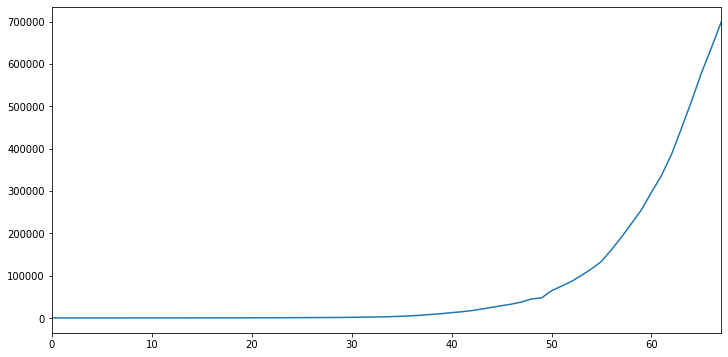

In [6]:
df['Confirmed'].plot(figsize=(12,6))

In [319]:
num_epochs = 100
batch_size = 32
split = 0.8
window = 18

In [320]:
training = split
total = df.shape[0]
train_index = int(total*training)

In [321]:
training_set = df[:train_index]

In [554]:
# sc = MinMaxScaler()
# sc = StandardScaler(with_mean=False)
sc = PowerTransformer(method='yeo-johnson', standardize=True)
# sc = Normalizer()
training_set_scaled = np.asarray(sc.fit_transform(pd.DataFrame(training_set['Confirmed']).values))

In [555]:

X_train = []
y_train = []
for i in range(window, train_index):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [556]:
print(X_train.shape, y_train.shape)

(36, 18, 1) (36,)


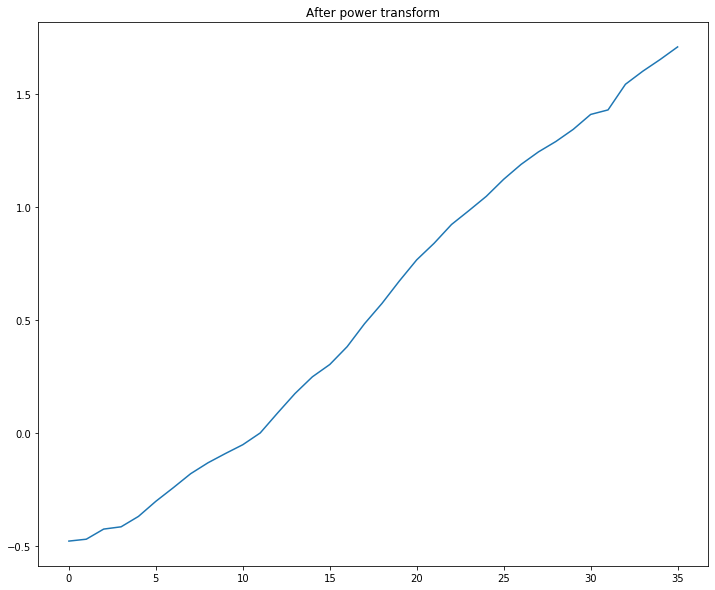

In [557]:
X_train[0]
plt.plot(y_train)
plt.title('After power transform')

plt.show()

In [518]:
testing_set = df[train_index:]
testing_set = pd.DataFrame(testing_set)
testing_set.head()

,Date,Confirmed,Day num
54,2020-03-17,116044,55
55,2020-03-18,133719,56
56,2020-03-19,161344,57
57,2020-03-20,190785,58
58,2020-03-21,223091,59


In [519]:
real_conf = testing_set['Confirmed'].values

In [520]:
test_set=testing_set['Confirmed']
test_set=pd.DataFrame(test_set)

In [521]:
inputs = df['Confirmed'][len(df) - len(testing_set) - window:].values
# print(inputs)
inputs = inputs.reshape(-1,1)
# print(inputs)
inputs = sc.transform(inputs)
# print(inputs)
X_test = []
for i in range(window, window+(total-train_index)):
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [522]:
# inputs
# total

In [523]:
Y_test = np.asarray(sc.transform(pd.DataFrame(testing_set['Confirmed']).reset_index(drop=True).values))

In [524]:
def root_mean_squared_logarithmic_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(K.log(y_pred + 1) - K.log(y_true + 1)))) 

In [538]:
model = Sequential()

model.add(LSTM(units = 256, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# model.add(LSTM(units = 128, return_sequences = True))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 128))
# model.add(Dropout(0.2))

# model.add(Dense(units = 256))

model.add(Dense(units = 1, activation="relu"))

model.compile(optimizer = 'adam', loss = root_mean_squared_logarithmic_error)

In [539]:
# early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min')
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='min')
cb = [checkpoint]

In [540]:
history = model.fit(X_train, y_train, 
                    epochs = num_epochs, 
                    batch_size = batch_size, 
                    callbacks = cb,
#                     validation_data = (X_test, Y_test),
                    validation_split = 0.1)

Train on 32 samples, validate on 4 samples
Epoch 1/100
32/32 [==============================] - 1s 19ms/step - loss: 0.5420 - val_loss: 0.7187
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 0.4718 - val_loss: 0.5225
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 0.4148 - val_loss: 0.3471
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 0.3656 - val_loss: 0.1761
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 0.3256 - val_loss: 0.0157
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 0.2944 - val_loss: 0.1779
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 0.2833 - val_loss: 0.3055
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 0.2852 - val_loss: 0.3312
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 0.2810 - val_loss: 0.2747
Epoch 10/100
32/32 [==============================] - 0s 2ms/step

Epoch 83/100
32/32 [==============================] - 0s 2ms/step - loss: 0.2455 - val_loss: 0.0407
Epoch 84/100
32/32 [==============================] - 0s 2ms/step - loss: 0.2452 - val_loss: 0.0411
Epoch 85/100
32/32 [==============================] - 0s 2ms/step - loss: 0.2456 - val_loss: 0.0407
Epoch 86/100
32/32 [==============================] - 0s 2ms/step - loss: 0.2452 - val_loss: 0.0391
Epoch 87/100
32/32 [==============================] - 0s 2ms/step - loss: 0.2452 - val_loss: 0.0381
Epoch 88/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2451 - val_loss: 0.0370
Epoch 89/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2450 - val_loss: 0.0373
Epoch 90/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2454 - val_loss: 0.0390
Epoch 91/100
32/32 [==============================] - 0s 2ms/step - loss: 0.2453 - val_loss: 0.0402
Epoch 92/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2451 - val_loss: 0.0413


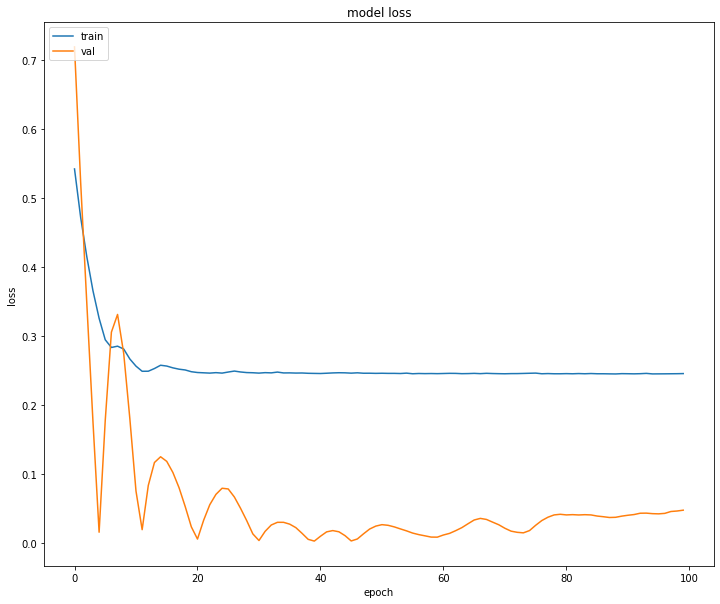

In [541]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [542]:
model.load_weights("model.h5")

In [543]:
predicted_conf = model.predict(X_test)

In [544]:
# predicted_conf=pd.DataFrame(predicted_conf)
X_test[0]

array([[0.57259898],
       [0.67194317],
       [0.76565637],
       [0.83900455],
       [0.92200102],
       [0.98341353],
       [1.04657611],
       [1.12206572],
       [1.18793975],
       [1.24327849],
       [1.28922113],
       [1.34299932],
       [1.40890447],
       [1.42893952],
       [1.54237153],
       [1.60029679],
       [1.65215716],
       [1.70768343]])

In [545]:
sc.inverse_transform(predicted_conf)
# X_test
# X_train
# real_conf

array([[119628.29],
       [138857.25],
       [159969.02],
       [183724.6 ],
       [211062.89],
       [242419.66],
       [277580.34],
       [316489.28],
       [358560.97],
       [403691.28],
       [452879.9 ],
       [506786.34],
       [565242.2 ],
       [626416.75]], dtype=float32)

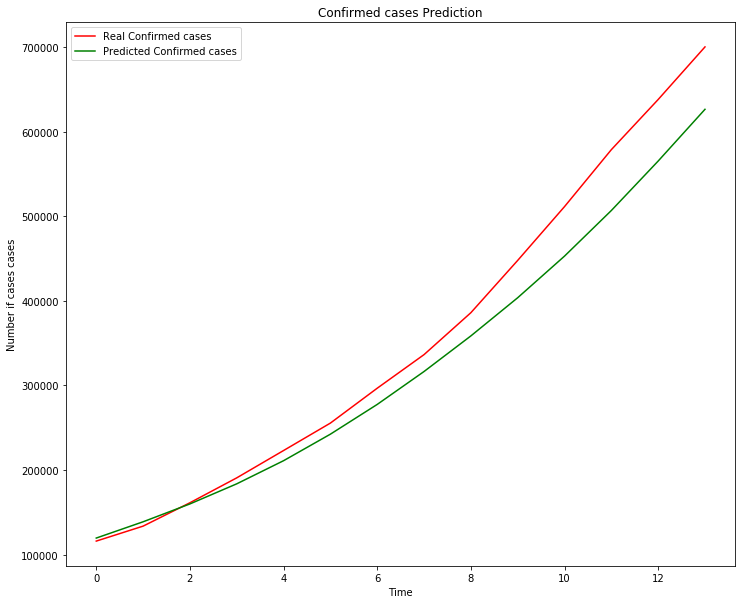

In [546]:
plt.rcParams['figure.figsize'] = [12, 10]
plt.plot(real_conf, color = 'red', label = 'Real Confirmed cases')
plt.plot(sc.inverse_transform(predicted_conf), color = 'green', label = 'Predicted Confirmed cases')
plt.title('Confirmed cases Prediction')
plt.xlabel('Time')
plt.ylabel('Number if cases cases')
plt.legend()
plt.show()

In [547]:
pred_conf = np.array(sc.inverse_transform(predicted_conf)).reshape(1,-1)[0]
real_conf = np.array(real_conf)
# pred_conf
real_conf

array([116044, 133719, 161344, 190785, 223091, 255518, 296737, 336454,
       385992, 447809, 511394, 578707, 637995, 700167], dtype=int64)

In [548]:

print("RMSLE = ", np.sqrt(np.mean(np.square(np.log(pred_conf + 1) - np.log(real_conf + 1)))))

RMSLE =  0.08171999665750283
